In a previous notebook https://github.com/AllenInstitute/aisynphys/blob/master/doc/connectivity_vs_distance.ipynb, we explored the distance dependenc on connectivity and how it can be modeled such that we can reliably compare connection probability among cells of different types probed at different distances. Here we extend that analysis to a number of other features in our dataset that are known to contribute to our ability to estimate the true, in vivo, connection probability. These factors fall into two main categories, those related to affects on neuronal processes due to the slicing procedure and our ability to detect small connections in noisy electrophysiological recordings.

Multipatch slice electrophysiology is one of the best methods for indepth characterization of synaptic connections. However, a consistent criticism  of slice physgiology is that measured connection probability (Cp) is a lower bounds of the true Cp due to severing of processes during slicing. We took multiple steps to reduce this liklihood in our dataset including the use of relatively thick slices (350um), targeting cells deep into the slice (at least 40um) and close together (typically 100um). We have additional measurements of axon and apical dendrite length before truncation from biocytin fills of recorded cells which we may use to estimage the affect on connection probability. 

It is also the case that electrophysiological recordings contain some amount of baseline noise. The level of this can be cell type dependent and may obscure very small responses unless we can average many many responses together, which is ultimately related to how long we record from the cells.

This notebook will explore these data and the impact it might have on Cp.

First let's import a bunch of stuff we might need including the database which holds all of our data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from aisynphys.database import default_db as db
from aisynphys.cell_class import CellClass, classify_cells, classify_pairs
from aisynphys.connectivity import measure_connectivity, connectivity_profile, pair_was_probed, measure_distance, GaussianModel, LinearModel, ExpModel
from aisynphys.ui.notebook import show_connectivity_profile, show_distance_binned_cp, show_connectivity_raster, show_connectivity_fit, set_distance_xticks
print(db.schema_version)

18


Pull out all pairs from mouse data and collect information on individual cells (axon/apical length, noise, length of recording, etc)

This can take some time to run and dumps the data out into a Pandas Dataframe where each row is a pair of cells that may have been probed for connectivity

In [2]:
pair_query = db.pair_query(project_name=['mouse V1 coarse matrix', 'mouse V1 pre-production'], preload='cell')
pair_query = pair_query.add_columns(db.Synapse.psp_amplitude)
pairs = pair_query.dataframe()
n_pairs = len(pairs)
def n_connections(row):
    i = row.name
    if i % 5000 == 0:
        print('%d / %d : %0.1f%%' % (i, n_pairs, i/n_pairs*100))
    expt_id = row['experiment_id'].iloc[0]
    pairs = db.query(db.Pair).join(db.Experiment).filter(db.Experiment.id==expt_id).all()
    n_syn = sum([pair.has_synapse for pair in pairs if pair.has_synapse is not None])
    return n_syn

pairs['n_syn'] = pairs.apply(lambda row: n_connections(row), axis=1)
pairs.head()

0 / 81452 : 0.0%
5000 / 81452 : 6.1%
10000 / 81452 : 12.3%
15000 / 81452 : 18.4%
20000 / 81452 : 24.6%
25000 / 81452 : 30.7%
30000 / 81452 : 36.8%
35000 / 81452 : 43.0%
40000 / 81452 : 49.1%
45000 / 81452 : 55.2%
50000 / 81452 : 61.4%
55000 / 81452 : 67.5%
60000 / 81452 : 73.7%
65000 / 81452 : 79.8%
70000 / 81452 : 85.9%
75000 / 81452 : 92.1%
80000 / 81452 : 98.2%


,id,experiment_id,pre_cell_id,post_cell_id,has_synapse,has_polysynapse,has_electrical,crosstalk_artifact,n_ex_test_spikes,n_in_test_spikes,...,tree_third_bt,tree_call,genes_detected,t_type,last_map,last_score,mapped_subclass,meta,psp_amplitude,n_syn
0,58800,1793,10369,10368,False,False,False,None,1026,0,...,None,None,None,None,None,None,None,None,NaN,5
1,109596,3534,19967,19966,False,False,False,None,644,29,...,None,None,None,None,None,None,None,None,NaN,2
2,109599,3534,19967,19970,False,False,False,None,637,34,...,None,None,None,None,None,None,None,None,NaN,2
3,109602,3534,19967,19973,False,False,False,None,668,668,...,None,None,None,None,None,None,None,None,NaN,2
4,109623,3534,19970,19973,False,False,False,None,699,699,...,None,None,None,None,None,None,None,None,NaN,2


This actually returns more cell-specific data than we need, so let's reduce it to the features we want and rename the columns to things that make sense (particularly identifing pre- and post-synaptic cells). We're also going to reduce this data down to only pairs that passed our QC for being probed for connectivity.

In [15]:
columns = ['has_synapse',
           'distance',
           'lateral_distance',
          'axon_truncation',
          'axon_trunc_distance',
          'apical_truncation',
          'apical_trunc_distance',
          'psp_amplitude',
          'cell_class_nonsynaptic',
          'n_ex_test_spikes',
          'n_in_test_spikes',
          'depth',
           'post_cell_id',
           'n_syn',]

column_names = ['has_synapse',
           'distance',
            'lateral_distance',
          'pre_axon_truncation',
          'post_axon_truncation',
          'pre_axon_trunc_dist',
          'post_axon_trunc_dist',
          'pre_apical_truncation',
          'post_apical_truncation',
          'pre_apical_trunc_dist',
          'post_apical_trunc_dist',
          'psp_amplitude',
          'pre_cell_class_nonsynaptic',
          'post_cell_class_nonsynaptic',
          'n_ex_test_spikes',
          'n_in_test_spikes',
           'pre_cell_depth',
           'post_cell_depth',
           'post_cell_id',
           'n_syn']

def n_test_spikes(row):
    if row['pre_cell_class_nonsynaptic']=='ex':
        return row['n_ex_test_spikes']
    if row['pre_cell_class_nonsynaptic']=='in':
        return row['n_in_test_spikes']

pairs_probed = pairs[columns]
pairs_probed.columns = column_names
pairs_probed['ex_probed'] = (pairs_probed['n_ex_test_spikes'] > 10) & (pairs_probed['pre_cell_class_nonsynaptic']=='ex')
pairs_probed['in_probed'] = (pairs_probed['n_in_test_spikes'] > 10) & (pairs_probed['pre_cell_class_nonsynaptic']=='in')
pairs_probed['n_test_spikes'] = pairs_probed.apply(lambda row: n_test_spikes(row), axis=1)
pairs_probed = pairs_probed[(pairs_probed['ex_probed'] ==True) | (pairs_probed['in_probed'] == True)]
pairs_probed['avg_depth'] = (pairs_probed['pre_cell_depth'] + pairs_probed['post_cell_depth']) / 2
pairs_probed['shallow_depth'] = pairs_probed.apply(lambda row: min([row['pre_cell_depth'], row['post_cell_depth']]), axis=1)
pairs_probed.head()

c:\users\stephanies\appdata\local\continuum\miniconda3\envs\py3\lib\site-packages\ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\users\stephanies\appdata\local\continuum\miniconda3\envs\py3\lib\site-packages\ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\users\stephanies\appdata\local\continuum\miniconda3\envs\py3\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

,has_synapse,distance,lateral_distance,pre_axon_truncation,post_axon_truncation,pre_axon_trunc_dist,post_axon_trunc_dist,pre_apical_truncation,post_apical_truncation,pre_apical_trunc_dist,...,n_in_test_spikes,pre_cell_depth,post_cell_depth,post_cell_id,n_syn,ex_probed,in_probed,n_test_spikes,avg_depth,shallow_depth
0,False,0.000115,0.000113,intact,unclear,NaN,NaN,intact,intact,NaN,...,0,0.000103,0.000117,10368,5,True,False,1026.0,0.000110,0.000103
1,False,0.000061,0.000007,intact,unclear,NaN,NaN,None,None,NaN,...,29,0.000070,0.000044,19966,2,False,True,29.0,0.000057,0.000044
2,False,0.000120,0.000038,intact,intact,NaN,NaN,None,None,NaN,...,34,0.000070,0.000077,19970,2,False,True,34.0,0.000073,0.000070
3,False,0.000148,0.000125,intact,unclear,NaN,NaN,None,None,NaN,...,668,0.000070,0.000041,19973,2,False,True,668.0,0.000055,0.000041
4,False,0.000153,0.000087,intact,unclear,NaN,NaN,None,None,NaN,...,699,0.000077,0.000041,19973,2,False,True,699.0,0.000059,0.000041


Just a few more data processing steps. Because it takes a lot of work to manually trace and measure cell processes such as axons and dendrites we took the strategy of measuring up to a point beyond which the process was termed "intact". For axons this distance was 200 microns, thus we are going to reformat "intact" axons into a numerical 200e-6. The measurement of cell depth from the slice surface is also subject to anomalies where if the suface of the slice isn't perfectly flat the measurement can make it seem like the cell is out of the plane of the tissue. For ease we will just say that we only care about cells in the slice and discard of everything with a depth < 0 and > 300 microns. Here we are averaging the depth of the pre- and post-synaptic cell for the pair depth. Finally we measure baseline noise on a per trial bases, we need to get an aggregate value for each cell which we will simply take as the mean of all trials.

This takes a long time to run, suggest doing it overnight

In [16]:
from aisynphys.connectivity import ConnectivityModel

mouse_pairs = pairs_probed.copy()
mouse_pairs['pre_axon_trunc_dist'].loc[(mouse_pairs['pre_axon_truncation'] == 'intact') & (mouse_pairs['pre_axon_trunc_dist'].isna())] = 200e-6 
mouse_pairs['avg_depth'].loc[(mouse_pairs['avg_depth'] < 0) | (mouse_pairs['avg_depth'] > 300e-6)] = None

n_pairs = len(mouse_pairs)
def baseline_rms_noise(row, clamp_mode):
    i = row.name
#     if i % 500 == 0:
#         print('%d / %d : %d%%' % (i, n_pairs, i/n_pairs*100))
    cell_id = row.post_cell_id
    q = db.query(db.PatchClampRecording)
    q = q.join(db.Recording).join(db.Electrode).join(db.Cell)
    q = q.filter(db.Cell.id==cell_id).filter(db.PatchClampRecording.clamp_mode==clamp_mode)
    pcrs = q.all()
    pcr_noise = [pcr.baseline_rms_noise for pcr in pcrs if pcr.qc_pass]
    if len(pcr_noise) > 1:
        return np.mean(pcr_noise)
    else:
        return None
    
mouse_pairs['post_cell_ic_rms_noise'] = mouse_pairs.apply(lambda row: baseline_rms_noise(row, 'ic'), axis=1)
mouse_pairs['post_cell_vc_rms_noise'] = mouse_pairs.apply(lambda row: baseline_rms_noise(row, 'vc'), axis=1)

e_pairs = mouse_pairs[(mouse_pairs['pre_cell_class_nonsynaptic']=='ex') & (mouse_pairs['ex_probed']==True)]
i_pairs = mouse_pairs[(mouse_pairs['pre_cell_class_nonsynaptic']=='in') & (mouse_pairs['in_probed']==True)]

c:\users\stephanies\appdata\local\continuum\miniconda3\envs\py3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Some ease of use functions for plotting and extenstion of our ConnectivityModel to include a Sigmoid curve. 

In [20]:
class SigmoidModel(ConnectivityModel):
    def __init__(self, pmax, size):
        self.pmax = pmax
        self.size = size

    def connection_probability(self, x):
        return (self.pmax / (1 + np.exp(-1 / self.size *(x - self.size))))
    

def cp_vs_x(probed, conn, ax, x_bins=np.arange(0, 500e-6, 40e-6), alpha=[0.005, 0.05], x_label='', ymax=0.3, scale=1e6):

    tickheight = ymax / 10
    offset = 2
    x_vals = np.linspace(x_bins[0], x_bins[-1], 200)
    
    _, cprop, lower, upper = connectivity_profile(conn, probed, x_bins)
    show_distance_binned_cp(x_bins, cprop, ax, ci_lower=lower, ci_upper=upper)
    
    ax.eventplot(probed.copy(), lineoffsets=-tickheight*offset, linelengths=tickheight, color=((0, 0, 0) + (alpha[0],)))
    ax.eventplot(probed[conn], lineoffsets=-tickheight*(offset-1), linelengths=tickheight, color=((0, 0, 0) + (alpha[1],)))
    ax.axhline(0, color=(0, 0, 0))
    
    interval = x_bins[1] - x_bins[0]
    xticks = np.arange(0, x_vals.max(), interval)
    ax.set_xticks(xticks)
    tick_labels = ['%0.1f'%(x*scale) for x in xticks]
    trailing_zero = [label.strip('.')[-1] == '0' for label in tick_labels]
    if all(trailing_zero):
        tick_labels = ['%0.0f'%(x*scale) for x in xticks] 
    ax.set_xticklabels(tick_labels, fontsize=10)
    ax.set_xlim(x_bins[0], x_bins[-1])
    
    y_vals = np.arange(0, ymax + 0.1, 0.1)
    ax.set_yticks([-tickheight*2, -tickheight] + list(y_vals))
    ax.set_yticklabels(['probed', 'connected'] + ['%0.1f'%x for x in y_vals], fontsize=10)
    ax.set_ylim(-tickheight*2.6, ymax)
    ax.set_xlabel(x_label, fontsize=12)
    
    return cprop
    
def cp_fit_x(data_df, x, ax, fit_label=None, units='µm', scale=1e6, x_bins=np.arange(0, 500e-6, 40e-6), color=(0.5, 0, 0),  
             model=GaussianModel, fixed_size=None, fixed_max=None, init=(0.1, 150e-6), bounds=((0.001, 1), (10e-6, 1e-3))):
    x_vals = np.linspace(x_bins[0], x_bins[-1], 200)
    probed = data_df[x].to_numpy(dtype='float')
    conn = data_df['has_synapse'].to_numpy(dtype='bool')
    mask = np.isfinite(probed) & np.isfinite(conn)
    fit = model.fit(probed[mask], conn[mask], fixed_size=fixed_size, fixed_max=fixed_max, init=init, bounds=bounds)
    if 'distance' in x:
        set_distance_xticks(x_vals, ax)
    else:
        ax.axhline(fit.pmax, color=color, ls='--')
    if fit_label is not None:
        label = 'pmax: %0.2f, size: %0.2f%s' % (fit.pmax, fit.size*scale, units)
        ax.plot(x_vals, fit.connection_probability(x_vals), color=color, label=label, lw=3)
        ax.legend(loc='upper right')
    else:
        ax.plot(x_vals, fit.connection_probability(x_vals), color=color, lw=3)

    return fit

OK, let's look at how Connection Proabability is related to these metrics and how we might fit them to a model. We will also look at the influence of how thresholding data for each of these metrics influences our previous estimate of connectivity as a function of intersomatic distance. Ultimately we would like to generate a model that encompasses all of these factors along with intersomatic distance to describe and correct our connection probability estimates.

Text(0.5, 1.0, 'Distribution for all pairs')

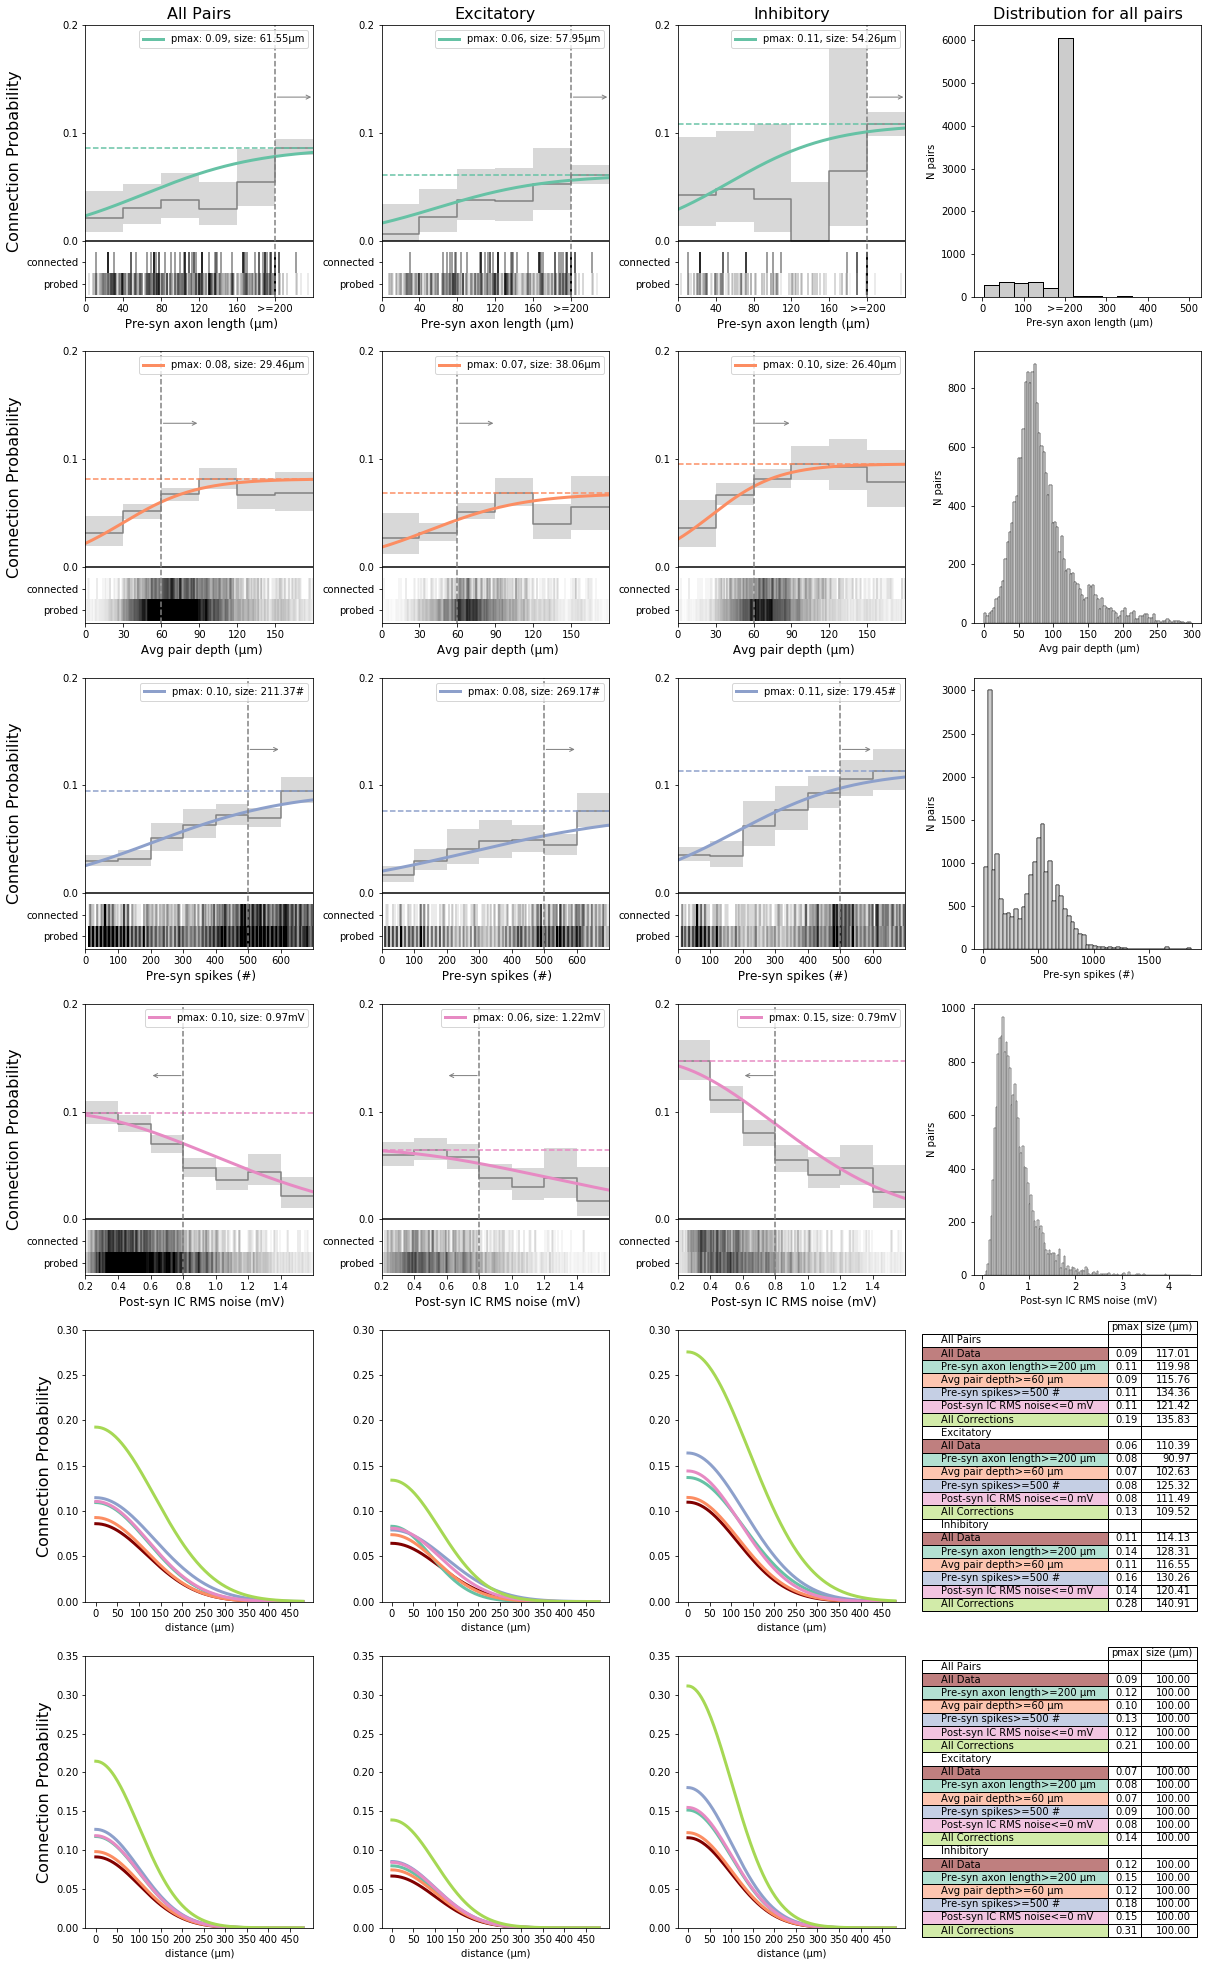

In [22]:

mouse_data = {'All Pairs': mouse_pairs, 'Excitatory': e_pairs, 'Inhibitory': i_pairs}
## Let's set up some metrics we want to look at. These dictionaries describe how we want the data to be binned, thresholded,
## and plotted
metrics = {
#         'distance': {'ymax': 0.2, 'xbins': np.arange(0, 500e-6, 40e-6), 'label': 'Intersomatic distance', 'alpha':[0.05, 0.5],
#                      'units': ('µm', 1e6), 'model': GaussianModel},
        'pre_axon_trunc_dist': {'ymax': 0.2, 'xbins': np.arange(0, 280e-6, 40e-6), 'alpha':[0.05, 0.5], 'fixed_max': True,
                               'threshold': (200e-6, 'lower'), 'label': 'Pre-syn axon length', 'units': ('µm', 1e6)}, 
        'avg_depth': {'ymax': 0.2, 'xbins': np.arange(0, 200e-6, 30e-6), 'alpha': [0.005, 0.05], 'threshold': (60e-6, 'lower'),
                     'label': 'Avg pair depth', 'units': ('µm', 1e6), 'fixed_max': True},
        'n_test_spikes': {'ymax': 0.2, 'xbins': np.arange(0, 800, 100), 'alpha': [0.01, 0.1], 'threshold': (500, 'lower'),
                          'units': ('#', 1), 'label': 'Pre-syn spikes', 'init': (0.05, 1000), 'bounds': ((0.001, 1), (10, 10e3)),
                         'fixed_max': True},
#         'n_syn': {'ymax': 0.4, 'xbins': np.arange(0, 12, 2), 'alpha': [0.005, 0.05], 'threshold': 2, 'label': '# Synapses',
#                   'init':(0.05, 3), 'bounds': ((0.001, 1), (0, 20))},
        'post_cell_ic_rms_noise': {'ymax': 0.2, 'xbins': np.arange(0.2e-3, 1.8e-3, 0.2e-3), 'alpha': [0.005, 0.05], 
                                   'units': ('mV', 1e3), 'label': 'Post-syn IC RMS noise', 'init': (0.05, 0.5e-3), 
                                   'bounds': ((0.001, 1),(0.2e-3, 3e-3)), 'model': GaussianModel, 'fixed_max': True,
                                  'threshold': (0.8e-3, 'upper')},
#         'post_cell_vc_rms_noise': {'ymax': 0.2, 'xbins': np.arange(3e-12, 50e-12, 5e-12), 'alpha': [0.005, 0.05],
#                                    'units': ('pA', 1e12), 'label': 'Post VC Noise', 'init': (0.05, 50e-12), 
#                                    'bounds': ((0.001, 1),(1e-12, 100e-12)), 'model': GaussianModel}
}

colors = sns.color_palette("Set2", n_colors=len(metrics) + 1)

cell_text = []
cell_text_fixed = []
columns = ('pmax', 'size (µm)')
rows = []
cell_colors = []

fig, axs = plt.subplots(len(metrics) + 2, 4, figsize=(20, 35))

plt.subplots_adjust(hspace=0.2, wspace=0.3)

[axs[a, 0].set_ylabel('Connection Probability', fontsize=16) for a in range(0, len(metrics)+2)]

## Work through each of our 3 datasets, all mouse pairs, excitatory connections, and inhibitory connections
for i, (name, data) in enumerate(mouse_data.items()):
    rows.append(name)
    cell_text.append(['',''])
    cell_text_fixed.append(['', ''])
    cell_colors.append('w')
    axs[0, i].set_title(name, fontsize=16)
    #Cp vs intersomatic distance
    conn = data['has_synapse'].to_numpy(dtype='bool')
    dist_bins = np.arange(0, 500e-6, 40e-6)
    dist_fit = cp_fit_x(data, 'lateral_distance', axs[-2, i], x_bins=dist_bins)
    rows.append('All Data')
    cell_text.append(['%0.2f' % dist_fit.pmax, '%0.2f' % (dist_fit.size*1e6)])
    cell_colors.append((0.5, 0, 0, 0.5))
    
    fixed_size = 100e-6
    dist_fit_fixed_size = cp_fit_x(data, 'lateral_distance', axs[-1, i], x_bins=dist_bins, fixed_size=fixed_size)
#     cp_vs_x(data['distance'].to_numpy(dtype='float'), conn, ax)
    cell_text_fixed.append(['%0.2f' % dist_fit_fixed_size.pmax, '%0.2f' % (dist_fit_fixed_size.size*1e6)])
    
    all_corrections = data.copy()
    # For each metric, plot the binned relationship with connection probability and attempt to fit
    for j, (metric, params) in enumerate(metrics.items()):
        ax  = axs[j, i]
        probed = data[metric].to_numpy(dtype='float')
        xbins = params['xbins']
        alpha = params['alpha']
        ymax = params['ymax']
        unit, scale = params['units']
        x_label = " %s (%s)" % (params['label'], unit)
        model = params.get('model', SigmoidModel)
        
        cprop = cp_vs_x(probed, conn, ax, x_bins=xbins, alpha=alpha, x_label=x_label, ymax=ymax, scale=scale)
        if 'axon' in metric:
            xtick_labels = ax.get_xticklabels()
            ind_200 = [i for i, tl in enumerate(xtick_labels) if tl.get_text()=='200'][0]
            xtick_labels[ind_200] = '>=200'
            ax.set_xticklabels(xtick_labels)
        
        init = params.get('init', (0.1, 150e-6))
        bounds = params.get('bounds', ((0.001, 1), (10e-6, 1e-3)))
        
        fixed_max = params.get('fixed_max', None)
        if fixed_max is True:
            fixed_max = np.max(cprop)
        fit = cp_fit_x(data, metric, ax,  fit_label='', units=unit, scale=scale, x_bins=xbins, color=colors[j], 
                       model=model, init=init, bounds=bounds, fixed_max=fixed_max)
        
        # Show metric distribution for reference
        sns.histplot(x=metric, data=mouse_pairs, ax=axs[j, 3], color=(0.8, 0.8, 0.8))
        xticks = axs[j, 3].get_xticks()
        xtick_labels = ['%0.0f' % (x*scale) for x in xticks]
        if 'axon' in metric:
            ind_200 = [i for i, tl in enumerate(xtick_labels) if tl=='200'][0]
            xtick_labels[ind_200] = '>=200'
        axs[j, 3].set_xticklabels(xtick_labels)
        axs[j, 3].set_xlabel(x_label)
        axs[j, 3].set_ylabel('N pairs')
        
        # If we can set a threshold where we think Cp levels off, reduce data to values >= / <= to that, depending
        # on the bounds and recompute. Accumulate all of these corrections into one final correction on 
        # Cp vs intersomatic distance fit
        threshold, bound = params.get('threshold')
        if threshold is not None:
            ax.axvline(threshold, color=(0.5, 0.5, 0.5), ls='--')
            if bound == 'lower':
                corrected_data = data[data[metric] >= threshold]
                all_corrections = all_corrections[all_corrections[metric] >= threshold]
                label = "%s>=%d %s" % (params['label'], threshold*scale, unit)
                ax.annotate('', xy=(threshold+(xbins[1]-xbins[0]), ymax-ymax/3), xytext=(threshold, ymax-ymax/3),
                            arrowprops={'arrowstyle': '->', 'color': (0.5, 0.5, 0.5)})
            if bound == 'upper':
                corrected_data = data[data[metric] <= threshold]
                all_corrections = all_corrections[all_corrections[metric] <= threshold]
                label = "%s<=%d %s" % (params['label'], threshold*scale, unit)
                ax.annotate('', xy=(threshold, ymax-ymax/3), xytext=(threshold-(xbins[1]-xbins[0]), ymax-ymax/3),
                            arrowprops={'arrowstyle': '<-', 'color': (0.5, 0.5, 0.5)})

            corrected_fit = cp_fit_x(corrected_data, 'lateral_distance', axs[-2, i], 
                                     x_bins=dist_bins, color=colors[j])
            corrected_fit_fixed_size = cp_fit_x(corrected_data, 'lateral_distance', axs[-1, i],  
                                                x_bins=dist_bins, color=colors[j], fixed_size=fixed_size)
            rows.append(label)
            cell_text.append(['%0.2f' % corrected_fit.pmax, '%0.2f' % (corrected_fit.size*1e6)])
            cell_text_fixed.append(['%0.2f' % corrected_fit_fixed_size.pmax, '%0.2f' % (corrected_fit_fixed_size.size*1e6)])
            cell_colors.append(colors[j] + (0.5,))
    
    # Cp vs intersomatic distance fit to all corrections
    all_corr_fit = cp_fit_x(all_corrections, 'lateral_distance', axs[-2, i], x_bins=dist_bins, 
             color=colors[-1])
    axs[-2, i].set_ylim(0, 0.3)
    all_corr_fit_fixed_size = cp_fit_x(all_corrections, 'lateral_distance', axs[-1, i], x_bins=dist_bins, 
             color=colors[-1], fixed_size=fixed_size)
    axs[-1, i].set_ylim(0, 0.35)
    rows.append('All Corrections')
    cell_text.append(['%0.2f' % all_corr_fit.pmax, '%0.2f' % (all_corr_fit.size*1e6)])
    cell_text_fixed.append(['%0.2f' % all_corr_fit_fixed_size.pmax, '%0.2f' % (all_corr_fit_fixed_size.size*1e6)])
    cell_colors.append(colors[-1] + (0.5,))

    
axs[-2, -1].axis("off")
axs[-1, -1].axis("off")

table = axs[-2, -1].table(cellText=cell_text,
                          rowLabels=rows,
                          rowColours=cell_colors,
                          colLabels=columns,
                          loc='center right')
table.set_fontsize(10)
table.auto_set_column_width(col=list(range(len(columns))))
table.scale(1,1.1)

table_fixed = axs[-1, -1].table(cellText=cell_text_fixed,
                          rowLabels=rows,
                          rowColours=cell_colors,
                          colLabels=columns,
                          loc='center right')
table_fixed.set_fontsize(10)
table_fixed.auto_set_column_width(col=list(range(len(columns))))
table_fixed.scale(1, 1.1)

axs[0, -1].set_title('Distribution for all pairs', fontsize=16)


In the plots above (top 4 rows) we see binned Connection Proabability vs X with a 95% confidence interval as the grey step line and shading. The raster below that shows a tick in the upper row if a connection was found at that value and the bottom row each tick represents a connection probed at that value. The colored line shows the model fit of the data with the colored dashed line being the fixed pmax value. We found that it was necessary to fix this value in order to get a reasonable fit to the data. The vertical grey dashed line depicts the threshold applied for use in calculating the correction. The direction of the arrow indicates what data was included. The histograms at the end of each row show the distribution of values for that metric. The bottom two rows show Gaussain fits to the Connection Probability vs intersomatic distance with either a free sigma value (top) or a fixed sigma value (bottom). The dark red curve is our baseline Cp vs Distance without any correction. Each colored line depicts the affect on the fit if the data is thresholded for that metric. For exampe, the pink curve shows the fit for data in which the postsynaptic noise level was <= 1mV. The lime green line shows the cummulative affect of all corrections. The tables to the right list the pmax and sigma values of each fit.